In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp datasets

# datasets
> Routines for loading/handling datasets

Many of these routines are dupes or mods from "audio-diffusion" repo by Zach Evans w/ contributions by Scott Hawley https://github.com/zqevans/audio-diffusion/blob/main/diffusion/utils.py

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
from __future__ import annotations  # for type hints, in LAION code samples
import numpy as np 
import torch
import torch.nn as nn
import torchaudio
from torchaudio import transforms as T
from torchvision import transforms as VT
import random
import os
import json
import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial
from aeiou.core import load_audio, get_audio_filenames, is_silence, untuple
from aeiou.viz import playable_spectrogram
from fastcore.utils import *
import webdataset as wds
import subprocess
import re

## Augmentation routines

Not all of these are used.  Code copied from https://github.com/zqevans/audio-diffusion/blob/main/diffusion/utils.py

In [ ]:
#|export
class PadCrop(nn.Module):
    "Grabs a random crop from an audio tensor, padding with zeros if necessary"
    def __init__(self, 
        n_samples,           # length of chunk to extract from longer signal
        randomize=True,      # draw cropped chunk from a random position in audio file
        redraw_silence=True, # a chunk containing silence will be replaced with a new one
        silence_thresh=-60,  # threshold in dB below which we declare to be silence
        max_redraws=2        # when redrawing silences, don't do it more than this many
        ):
        super().__init__()
        store_attr()     # sets self.___ vars automatically
    
    def draw_chunk(self, signal):
        "here's the part that actually draws a cropped/padded chunk of audio from signal"
        n, s = signal.shape
        start = 0 if (not self.randomize) else torch.randint(0, max(0, s - self.n_samples) + 1, []).item()
        end = start + self.n_samples
        chunk = signal.new_zeros([n, self.n_samples])
        chunk[:, :min(s, self.n_samples)] = signal[:, start:end]
        return chunk
    
    def __call__(self, signal):
        "when part of the pipline, this will grab a padded/cropped chunk from signal"
        chunk = self.draw_chunk(signal)
        num_redraws = 0
        while self.redraw_silence and is_silence(chunk, thresh=self.silence_thresh) and (num_redraws < self.max_redraws):
            #print(f"    PadCrop: Got silence.  Redrawing. Try {num_redraws+1} of {self.max_redraws}")
            chunk, num_redraws = self.draw_chunk(signal), num_redraws+1
        return chunk

In [ ]:
#|export    
class PhaseFlipper(nn.Module):
    "she was PHAAAAAAA-AAAASE FLIPPER, a random invert yeah"
    def __init__(self, 
        p=0.5  # probability that phase flip will be applied
        ):
        super().__init__()
        self.p = p
    def __call__(self, signal):
        return -signal if (random.random() < self.p) else signal

In [ ]:
#|export  
class FillTheNoise(nn.Module):
    "randomly adds a bit of noise, just to spice things up"
    def __init__(self, 
        p=0.33       # probability that noise will be added
        ):
        super().__init__()
        self.p = p
    def __call__(self, signal):
        return signal + 0.25*random.random()*(2*torch.rand_like(signal)-1) if (random.random() < self.p) else signal

In [ ]:
#|export    
class RandPool(nn.Module):
    "Perform pooling with random-sized kernels"
    def __init__(self, p=0.2):
        super().__init__()
        self.p, self.maxkern = p, 100
    def __call__(self, signal):
        if (random.random() < self.p):
            ksize = int(random.random()*self.maxkern)
            avger = nn.AvgPool1d(kernel_size=ksize, stride=1, padding=1)
            return avger(signal)
        else:
            return signal

In [ ]:
#|export
class NormInputs(nn.Module):
    "Normalize inputs to [-1,1]. Useful for quiet inputs"
    def __init__(self, 
        do_norm=True    # controllable parameter for turning normalization on/off
        ):
        super().__init__()
        self.do_norm = do_norm
        self.eps = 1e-2
    def __call__(self, signal):
        return signal if (not self.do_norm) else signal/(torch.amax(signal,-1)[0] + self.eps)

In [ ]:
#|export    
class Mono(nn.Module):
    "convert audio to mono"
    def __call__(self, signal):
        return torch.mean(signal, dim=0) if len(signal.shape) > 1 else signal

In [ ]:
#|export
class Stereo(nn.Module):
    "convert audio to stereo"
    def __call__(self, signal):
        signal_shape = signal.shape
        # Check if it's mono
        if len(signal.shape) == 1: # s -> 2, s
            signal = signal.unsqueeze(0).repeat(2, 1)
        elif len(signal_shape) == 2:
            if signal.shape[0] == 1: #1, s -> 2, s
                signal = signal.repeat(2, 1)
            elif signal.shape[0] > 2: #?, s -> 2,s
                signal = signal[:2, :]    
        return signal

In [ ]:
#|export    
class RandomGain(nn.Module):
    "apply a random gain to audio"
    def __init__(self, min_gain, max_gain):
        super().__init__()
        self.min_gain = min_gain
        self.max_gain = max_gain

    def __call__(self, signal):
        gain = random.uniform(self.min_gain, self.max_gain)
        signal = signal * gain
        return signal

## Masking (of inputs)

First a couple utility routines before the main masking routine:

In [ ]:
#|export
def smoothstep(x, # a tensor of coordinates across a domain, e.g. [0,1]
    edge0=0.4, # "zero"/"left" side of smoothstep
    edge1=0.6, # "one"/"right" side of smoothstep
    ):
    "an s-shaped curve, 0's on left side and 1's at right side, with gradient zero at all 1's and 0's. cf. https://en.wikipedia.org/wiki/Smoothstep"
    x = torch.where(x < edge0, 0, x)
    x = torch.where(x > edge1, 1, x)
    x = torch.where( torch.logical_and(x >= edge0, x <= edge1) , (x - edge0) / (edge1 - edge0), x )
    return x * x * (3 - 2 * x)

In [ ]:
#|export
def smoothstep_box(
    coords, # tensor of coordinate values
    edges = (0.2,0.3,0.5,0.6) # (left 1's boundary, left 0's boundary, right 0's boundary, right 1's boundary)
    ): 
    "makes a flat region of zeros that transitions smoothly to 1's via smoothsteps at the sides"
    assert edges[0] < edges[1] and edges[1] < edges[2] and edges[2] < edges[3], f"Edges should be in increasing order but you have edges = {edges}"
    right = smoothstep(coords, edge0=edges[2], edge1=edges[3])
    left = 1 - smoothstep(coords, edge0=edges[0], edge1=edges[1])
    return left + right

Testing `smoothstep_box`: 

In [ ]:
import matplotlib.pyplot as plt 

device = cuda


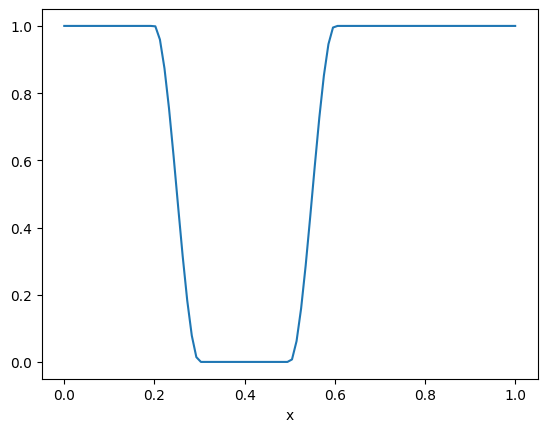

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"device = {device}")
x = torch.linspace(0,1,steps=100).to(device)
y = smoothstep_box(x)
plt.plot(x.cpu(), y.cpu())
plt.xlabel('x')
plt.show()

And now the main masking routine: 

In [ ]:
#|export
class RandMask1D(nn.Module):
    "Performs masking or 'cutout' along 1d data. Can support 'smooth sides' to the cutouts"
    def __init__(self, 
        mask_frac=0.25,        # fraction of total input that is to be masked (helps compute no. of masked regions)
        mask_width=0.1,        # either a fraction of the total length (float < 1) or an exact integer value for length of each masked region
        mask_type='simple',    # 'simple'=hard sides to cuts, 'softstep'=smooth sides
        edge_width=0.2,        # for mask_type=smoothstep, fraction or integer value of transition regions to come in from the sides of zeros region
        verbose = False,       # show logging info
        ):
        super().__init__()
        if mask_width < 1: self.mask_width_frac = mask_width   # if float is given, set fraction of chunk length for each mask
        self.mask_frac,  self.mask_width, self.mask_type, self.edge_width, self.verbose = mask_frac, mask_width, mask_type, edge_width, verbose
        self.mask = None       # mask is only setup (once and for all) when forward() is called

    def make_single_mask(self, x, min_val=0):
        "allocate a 1D group of min_vals (zeros) amidst a bunch of 1's. Put the zeros/min_vals values in the middle"
        start = max(0, (x.shape[-1] - self.mask_width)//2 ) 
        end =   min(start + self.mask_width, x.shape[-1])   # don't go over the edge
        if self.mask_type == 'simple': 
            self.mask = torch.ones(x.shape[-1]).to(x.device)
            self.mask[start:end] = min_val                  
        elif self.mask_type == 'smoothstep':       
            coords = torch.linspace(0,1, steps=x.shape[-1]).to(x.device)
            ew = self.edge_width if isinstance(self.edge_width,int) else int((end-start)*self.edge_width) # edge width in samples
            self.mask = smoothstep_box(coords, edges=[coords[i] for i in [start, start+ew, end-ew, end]])
        else:
            assert False, f"Error: Unsupported mask type: '{self.mask_type}'"

    def mask_once_1channel(self, 
        xc,            # one channel of x
        move=None,     # amount by which to shift the mask around, in samples
        start_loc = None, # can specify where to start from (typically leave this as None)
        ):
        "excises one mask region for one channel (hence '_1c') in one batch"
        # shift the mask forward or backward   
        shift_by = int((2*np.random.rand()-1)*xc.shape[-1]) if start_loc is None else start_loc
        mask_view = torch.roll(self.mask, shift_by, -1).to(xc.device)   # move the mask around (as a view of original mask tensor)
        return xc * mask_view # this does the excising, not in place (so xc stays unchanged)

    def forward(self, x):
        if self.mask is None:  # setup the mask if it hasn't been setup already
            if isinstance(self.mask_width, float):  # convert it from a fraction to an integer number of samples
                self.mask_width = int(x.shape[-1] * self.mask_width_frac)
            self.make_single_mask(x)
            self.n_masks =  int(self.mask_frac * x.shape[-1]/self.mask_width)  # number of mask regions to add per channel. we will not worry about whether masks end up overlapping or not
            if self.verbose: print("self.mask_width, self.n_masks = ",self.mask_width, self.n_masks)

        out = x.clone().to(x.device)  # make a copy so that we don't overwrite x
        assert len(x.shape) >= 3, f"Expected x to have 3 or more dimensions but x.shape = {x.shape}" # x.shape should be [b,c,n_samples]
        for bi in range(x.shape[0]):  # TODO: gotta be a way to do this all at once instead of 3 loops! 
            for c in range(x.shape[1]):  
                for i in range(self.n_masks):
                    out[bi,c,:] = self.mask_once_1channel(out[bi,c,:]) # this operation is in place
        return out


Let's test the simple mask ("hard cuts"):

self.mask_width, self.n_masks =  500 3


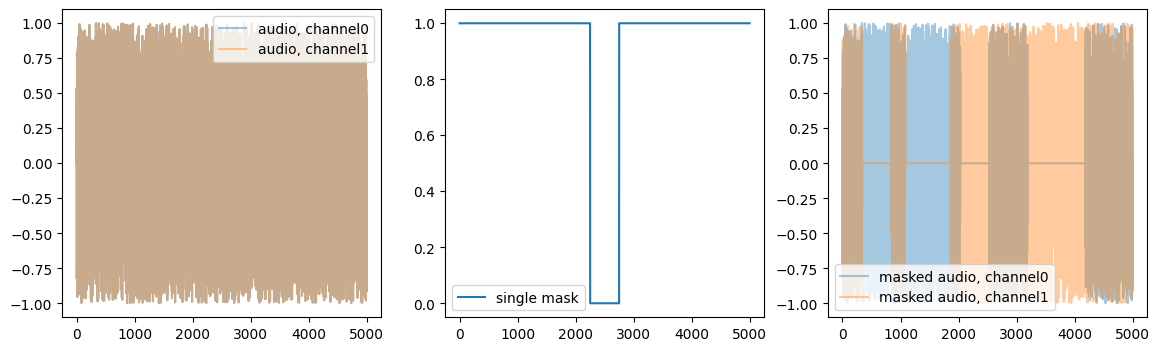

In [ ]:
torch.manual_seed(0)
audio = (2*torch.rand((2,2,5000))-1).to(device)
mask_op = RandMask1D(mask_frac=0.3, mask_width=0.1, verbose=True)
masked = mask_op.forward(audio)

# routine to display what we got
def display_mask_data(audio, mask_op, masked):
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[1].plot(mask_op.mask.cpu(), label='single mask')
    for c in range(audio.shape[1]): # show different channels of masked audio
        ax[0].plot(audio[0,0,:].cpu(),  alpha=0.4, label=f'audio, channel{c}')
        ax[2].plot(masked[0,c,:].cpu(), alpha=0.4, label=f'masked audio, channel{c}')
    for i in range(3): ax[i].legend()
    plt.show() 

display_mask_data(audio, mask_op, masked)

Now test the mask with "softstep" sides:

self.mask_width, self.n_masks =  1000 2


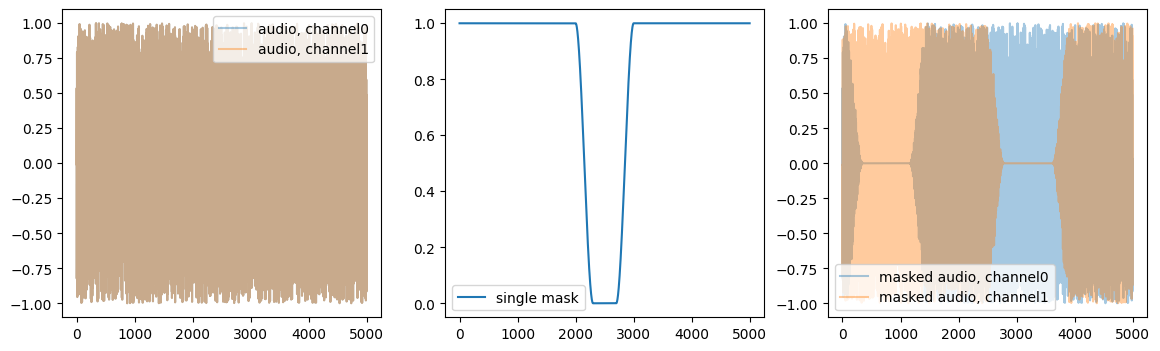

In [ ]:
mask_op = RandMask1D(mask_frac=0.4, mask_width=0.2, mask_type='smoothstep', edge_width=0.3, verbose=True)
masked = mask_op.forward(audio)
display_mask_data(audio, mask_op, masked)

## WebDataset support


### Background Info
Refer to the official [WebDataset Repo on GitHub](https://github.com/webdataset/webdataset).

> WebDataset makes it easy to write I/O pipelines for large datasets. Datasets can be stored locally or in the cloud.

They use the word "shards" but never define what "shard" means.  I (S.H.) surmise they mean the groups of data files which are gathered into a series of `.tar` files -- the `.tar` files are the shards? 

cf. Video Tutorial: ["Loading Training Data with WebDataset"](https://www.youtube.com/watch?v=mTv_ePYeBhs).

The recommended usage for AWS S3 can be seen in [this GitHub Issue comment by tmbdev] (https://github.com/webdataset/webdataset/issues/21#issuecomment-706008342): 

```Python
url = "pipe:s3cmd get s3://bucket/dataset-{000000..000999}.tar -"
dataset = wds.Dataset(url)...
```
> ^[sic.] `s3cmd get` should read `aws s3 cp`. 

That URL is expecting a contiguously-numbered range of .tar files. So if the file numbers are contiguous (no gaps), then we'll have an easy time. Otherwise, there are ways to pass in a long list of similar "pipe:...tar" 'urls' for each and every tar file, which is still not a big deal though it may appear messier. 

> NOTE: be prepared for extensive 'testing cases' shown for the following routines.  

### General utility: `get_s3_contents()`

In [ ]:
#|export
def get_s3_contents(
    dataset_path,     # "name" of the dataset on s3
    s3_url_prefix='s3://s-laion-audio/webdataset_tar/',  # s3 bucket to check
    filter='',       # only grab certain filename / extensions
    recursive=True,  # check all subdirectories. RECOMMEND LEAVING THIS TRUE
    debug=False,     # print debugging info (don't rely on this info staying consistent)
    ):
    "Gets a list of names of files or subdirectories on an s3 path"
    if (dataset_path != '') and (not dataset_path.endswith('/')): 
        dataset_path = dataset_path + '/'
    dataset_path = dataset_path.replace('//','/') # aws is baffled by double slashes in dir names
    if not recursive:
        run_ls = subprocess.run(['aws','s3','ls',f'{s3_url_prefix}{dataset_path}'], capture_output=True)
    else:
        run_ls = subprocess.run(['aws','s3','ls',f'{s3_url_prefix}{dataset_path}','--recursive'], capture_output=True)
        run_ls = subprocess.run(["awk",'{$1=$2=$3=""; print $0}'], input=run_ls.stdout, capture_output=True)
        run_ls = subprocess.run(["sed",'s/^[ \t]*//'], input=run_ls.stdout, capture_output=True)
    contents = run_ls.stdout.decode('utf-8').split('\n') 
    contents = [x.strip() for x in contents if x]      # list of non-empty strings, without leading whitespace
    contents = [x.replace('PRE ','') if (x[-1]=='/') else x for x in contents]  # directories
    #contents = [''.join(x.split(' ')[4:]) if (x[-1]!='/') else x for x in contents]    # files
    if recursive:  # recursive flag weirdly adds redundant extr directory name taken from s3 url, so we should strip
        main_dir = s3_url_prefix.split('/')[-2]
        if debug: print("main_dir =",main_dir)
        contents = [x.replace(f'{main_dir}/','').replace(dataset_path,'').replace('//','/') for x in contents]
        if debug: print("contents = ",contents)
    return [x for x in contents if filter in x] # return filtered list

Let's test that on the FSD50K dataset:
> Note: These tests will only work on systems on which you have valid AWS credentials, e.g. the Stability cluster. If the docs show a bunch of blanks in what follows, that's why. 

In [ ]:
#| eval: false
get_s3_contents('130000_MIDI_SONGS', recursive=False)

[]

In [ ]:
#| eval: false
get_s3_contents('FSD50K/test/')

[]

And let's try filtering for only tar files: 

In [ ]:
#| eval: false
tar_names = get_s3_contents('FSD50K/test', filter='tar')
tar_names

[]

List all LAION audio datasets:

In [ ]:
get_s3_contents('',recursive=False)

List all of dadabots' `ekto` tar files in their `1/` directory:

In [ ]:
#| eval: false
contents = get_s3_contents('ekto/1/', s3_url_prefix='s3://s-harmonai/datasets/', recursive=True, debug=False)
contents[0:10] # let's just print 10 of them

### For contiguous file-number lists...

Maybe the range of tar numbers is contigous.  (In the LAION AudoiDataset archives, they are each contiguous within `train/`, `valid/`, and `test/` subsets.) If so, let's have something to output that range:

In [ ]:
#|export 
def get_contiguous_range(
    tar_names, # list of tar file names, although the .tar part is actually optional
    ):
    "given a string of tar file names, return a string of their range if the numbers are contiguous. Otherwise return empty string"
    if len(tar_names) == 0:  return ''
    elif len(tar_names) == 1: return tar_names[-1]
    just_nums = [x.replace('.tar','') for x in tar_names]
    just_nums.sort(key=int) # sorts numerically but meaningfully preserves leading zeros in strings
    nums_arr = np.asarray(just_nums,  dtype=int)
    is_contiguous =  np.abs( (nums_arr - np.roll(nums_arr,1)) [1:] ).max() == 1
    if is_contiguous:   # {000000..000999}
        return '{' + f'{just_nums[0]}..{just_nums[-1]}' +'}'
    else:
        print("get_contiguous_range: File numbers not continuous")  # have to do more work
        return '' # empty string will signify no dice; signal for more work to be done

In [ ]:
#| eval: false
cont_range = get_contiguous_range(tar_names)
cont_range

Test if leading zeros are preserved:

In [ ]:
#| eval: false
get_contiguous_range(['0000'+x for x in tar_names])  

Test zero-element and single element versions:

In [ ]:
print(get_contiguous_range([]))
print(get_contiguous_range([1]))

And show that '.tar' is optional:

In [ ]:
get_contiguous_range(['01','02','3']) 

....So, if a contiguous range of tar file names is available in a WebDataset directory, then we can just use the native WebDataset creation utilities and can ignore all the other %$#*& that's about to follow below. 

Let's test the simple version first:

In [ ]:
#| eval: false
s3_url_prefix='s3://s-laion-audio/webdataset_tar/'
url = f"pipe:aws s3 cp {s3_url_prefix}FSD50K/test/{cont_range}.tar -"  # 'aws get' is not a thing. 'aws cp' is
print(url)
dataset = wds.WebDataset(url)

`WebDataset` is a kind of `IterableDataset`, so we can iterate over it directly:

In [ ]:
#| eval: false
## NOTE TO SELF: DON'T RUN THIS ON STABILITY CLUSTER HEADNODE (But Jupyter nodes are fine)
for sample in dataset:  
    for k,v in sample.items():  # print the all entries in dict
        print(f"{k:20s} {repr(v)[:50]}")
    break                       # abort after first dict

In [ ]:
#| eval: false
audio_keys = ("skeez","jop")
found_key, rewrite_key = '', ''
for k,v in sample.items():  # print the all entries in dict
    for akey in audio_keys:
        if k.endswith(akey): 
            found_key, rewrite_key = k, akey
            break
    if '' != found_key: break 
if '' == found_key:  # got no audio!   
    print("Error: No audio in this sample:")
    for k,v in sample.items():  # print the all entries in dict
        print(f"{k:20s} {repr(v)[:50]}")

There's a built-in decoder for various audio formats, so we can just use: 

In [ ]:
#| eval: false
dataset = wds.WebDataset(url).decode(wds.torch_audio) # throw out the json
sample = next(iter(dataset))
audio, sr = (sample["flac"])
playable_spectrogram(audio, specs='wave_mel', output_type='live')

Let's check the contents of the `georgeblood` Internet Archive:

In [ ]:
#|eval: false
#urls = get_all_s3_urls(names=['georgeblood'], subsets=[], s3_url_prefix='s3://iarchive-stability/')
urls = ['pipe:aws s3 cp s3://iarchive-stability/georgeblood/150370.tar -']
dataset = wds.WebDataset(urls).decode(wds.torch_audio).shuffle(10)
for sample in dataset:  
    for k,v in sample.items():  # print the all entries in dict
        print(f"{k:20s} {repr(v)[:75]}")
    break  

Here's a utility routine we'll use further down:

In [ ]:
#|export 
def fix_double_slashes(s, debug=False):
    "aws is pretty unforgiving compared to 'normal' filesystems. so here's some 'cleanup'"
    cdsh_split = s.split('://')
    assert (len(cdsh_split) <= 2) and (len(cdsh_split) > 0), f'what kind of string are you using? s={s}'
    post = cdsh_split[-1]
    while '//' in post: 
        post = post.replace('//','/')
    if len(cdsh_split) > 1: 
        return cdsh_split[0] + '://' + post
    else:
        return post

Test that: 

In [ ]:
s = 'pipe:aws s3 --cli-connect-timeout 0 cp s3://s-harmonai//datasets//ekto/1//ekto-000006.tar -'
print(fix_double_slashes(s, debug=True))
s = 'hey/ho//lets/go'
print(fix_double_slashes(s, debug=True))

### Non-contiguously-numbered lists of tar files...

Here we'll just get individual URLs for every tar file possible for a given list of dataset names

In [ ]:
#|export 

def get_all_s3_urls(
    names=['FSD50K'],    # list of all valid [LAION AudioDataset] dataset names 
    subsets=[''],   # list of subsets you want from those datasets, e.g. ['train','valid']
    s3_url_prefix='s3://s-laion-audio/webdataset_tar/',   # prefix for those
    recursive=True,  # recursively list all tar files in all subdirs
    filter_str='tar', # only grab files with this substring
    debug=False,     # print debugging info -- note: info displayed likely to change at dev's whims
    ): 
    "get urls of shards (tar files) for multiple datasets in one s3 bucket"
    if s3_url_prefix[-1] != '/':  s3_url_prefix = s3_url_prefix + '/'
    urls = []
    names = [''] if names == [] else names # for loop below
    subsets = [''] if subsets == [] else subsets # for loop below
    for name in names:
        if debug: print(f"get_all_s3_urls: {s3_url_prefix}{name}:")
        for subset in subsets:
            contents_str = fix_double_slashes(f'{name}/{subset}/')
            if debug: print("contents_str =",contents_str)
            tar_list = get_s3_contents(contents_str, s3_url_prefix=s3_url_prefix, recursive=recursive, filter=filter_str, debug=debug)
            for tar in tar_list:
                tar = tar.replace(" ","\ ").replace("(","\(").replace(")","\)") # escape spaces and parentheses for shell
                s3_path  = f"{name}/{subset}/{tar} -"
                while '//' in s3_path:  # aws hates double-slashes
                    s3_path = s3_path.replace('//','/')
                request_str = f"pipe:aws s3 --cli-connect-timeout 0 cp {s3_url_prefix}{s3_path}" 
                if debug: print("request_str = ",request_str)
                urls.append(fix_double_slashes(request_str))
    #urls = [x.replace('tar//','tar/') for x in urls] # one last double-check
    return urls

In [ ]:
#| eval: false
urls = get_all_s3_urls(names=['ekto/1'], recursive=True, s3_url_prefix='s3://s-harmonai/datasets/', debug=False) # CJ's new dataset
urls[0:10]  # let's just print 10 of them instead of the whole thing

In [ ]:
#|eval: false
urls = get_all_s3_urls(names=['georgeblood'], s3_url_prefix='s3://iarchive-stability/', subsets=[])
len(urls)

# AudioDataset class

The flagship class!

In [ ]:
#|export
class AudioDataset(torch.utils.data.Dataset):
    """
    Reads from a tree of directories and serves up cropped bits from any and all audio files
    found therein. For efficiency, best if you "chunk" these files via chunkadelic
    modified from https://github.com/drscotthawley/audio-diffusion/blob/main/dataset/dataset.py
    """
    def __init__(self, 
        paths,             # list of strings of directory (/tree) names to draw audio files from
        sample_rate=48000, # audio sample rate in Hz
        sample_size=65536, # how many audio samples in each "chunk"
        random_crop=True,  # take chunks from random positions within files
        load_frac=1.0,     # fraction of total dataset to load
        cache_training_data=False,  # True = pre-load whole dataset into memory (not fully supported)
        num_gpus=8,        # used only when `cache_training_data=True`, to avoid duplicates,
        redraw_silence=True, # a chunk containing silence will be replaced with a new one
        silence_thresh=-60,  # threshold in dB below which we declare to be silence
        max_redraws=2,        # when redrawing silences, don't do it more than this many
        augs='Stereo(), PhaseFlipper()', # list of augmentation transforms **after PadCrop**, as a string
        verbose=False,       # whether to print notices of reasampling or not
        ):
        super().__init__()
    
        print("augs =",augs)
        # base_augs are always applied
        base_augs = 'PadCrop(sample_size, randomize=random_crop, redraw_silence=redraw_silence, silence_thresh=silence_thresh, max_redraws=max_redraws)'
        self.augs = eval(f'torch.nn.Sequential( {base_augs}, {augs} )')  if augs is not None else None 
        self.silence_thresh = silence_thresh
        self.redraw_silence = redraw_silence
        self.max_redraws = max_redraws
        self.sr = sample_rate
        self.cache_training_data = cache_training_data
        self.verbose = verbose

        self.filenames = get_audio_filenames(paths)
        print(f"AudioDataset:{len(self.filenames)} files found.")
        self.n_files = int(len(self.filenames)*load_frac)
        self.filenames = self.filenames[0:self.n_files]
        if cache_training_data: self.preload_files()

        self.convert_tensor = VT.ToTensor()

    def load_file_ind(self, file_list,i): # used when caching training data
        return load_audio(file_list[i], sr=self.sr, verbose=self.verbose).cpu()

    def get_data_range(self): # for parallel runs, only grab part of the data -- OBVIATED BY CHUNKING.
        start, stop = 0, len(self.filenames)
        try:
            local_rank = int(os.environ["LOCAL_RANK"])
            world_size = int(os.environ["WORLD_SIZE"])
            interval = stop//world_size
            start, stop = local_rank*interval, (local_rank+1)*interval
            return start, stop
        except KeyError as e: # we're on GPU 0 and the others haven't been initialized yet
            start, stop = 0, len(self.filenames)//self.num_gpus
            return start, stop

    def preload_files(self):
        print(f"Caching {self.n_files} input audio files:")
        wrapper = partial(self.load_file_ind, self.filenames)
        start, stop = self.get_data_range()
        with Pool(processes=cpu_count()) as p:   # //8 to avoid FS bottleneck and/or too many processes (b/c * num_gpus)
            self.audio_files = list(tqdm.tqdm(p.imap(wrapper, range(start,stop)), total=stop-start))

    def __len__(self):
        return len(self.filenames)
    
    
    def get_next_chunk(self, 
        idx     # the index of the file within the list of files
        ):
        "The heart of this whole dataset routine"
        audio_filename = self.filenames[idx]
        try:
            if self.cache_training_data:
                audio = self.audio_files[idx] # .copy()
            else:
                audio = load_audio(audio_filename, sr=self.sr, verbose=self.verbose)
            if self.augs is not None:         #Run augmentations on this sample (including random crop)
                audio = self.augs(audio)
            audio = audio.clamp(-1, 1)
            return audio
        
        except Exception as e:
            print(f'AudioDataset.get_next_chunk: Error loading file {audio_filename}: {e}')
            return None
        
        
    def __getitem__(self, 
        idx     # the index of the file within the list of files
        ):
        audio = self.get_next_chunk(idx)
        # even with PadCrop set to reject silences, it could be that the whole file is silence; 
        num_redraws = 0 
        while (audio is None) or (self.redraw_silence and is_silence(audio, thresh=self.silence_thresh) \
            and (num_redraws < self.max_redraws)):
            #print(f"AudioDataset.__getitem__: Got None or silence (torch.max = {torch.max(audio)})  Redrawing. Attempt {num_redraws+1} of {self.max_redraws}")
            next_idx = random.randint(0,len(self.filenames)-1)     # pick some other file at random
            audio, num_redraws = self.get_next_chunk(next_idx), num_redraws+1
               
        return self[random.randrange(len(self))] if (audio is None) else audio

Quick check to catch minor errors:

In [ ]:
#| eval: false
dataset = AudioDataset('examples/', augs='Stereo(), PhaseFlipper(), FillTheNoise(), NormInputs()')
signal = dataset.__getitem__(0)
print("signal.shape =",signal.shape)

print("\nStereo -------------")
dataset2 = AudioDataset('examples/', augs='Stereo(), PhaseFlipper()')
signal2 = dataset2.__getitem__(0)
print("signal2.shape =",signal2.shape)

augs = Stereo(), PhaseFlipper(), FillTheNoise(), NormInputs()
AudioDataset:2 files found.
signal.shape = torch.Size([2, 65536])

Stereo -------------
augs = Stereo(), PhaseFlipper()
AudioDataset:2 files found.
signal2.shape = torch.Size([2, 65536])


In [ ]:
#| export
class IterableAudioDataset(torch.utils.data.IterableDataset):
    "Iterable version of AudioDataset, used with Chain (below)"
    def __init__(self, 
        paths,             # list of strings of directory (/tree) names to draw audio files from
        sample_rate=48000, # audio sample rate in Hz
        sample_size=65536, # how many audio samples in each "chunk"
        random_crop=True,  # take chunks from random positions within files
        load_frac=1.0,     # fraction of total dataset to load
        cache_training_data=False,  # True = pre-load whole dataset into memory (not fully supported)
        num_gpus=8,        # used only when `cache_training_data=True`, to avoid duplicates,
        redraw_silence=True, # a chunk containing silence will be replaced with a new one
        silence_thresh=-60,  # threshold in dB below which we declare to be silence
        max_redraws=2,        # when redrawing silences, don't do it more than this many
        augs='Stereo(), PhaseFlipper()', # list of augmentation transforms **after PadCrop**, as a string
        verbose=False,       # whether to print notices of reasampling or not
        ):
        super().__init__()
        self.this = AudioDataset(paths, sample_rate=sample_rate, sample_size=sample_size, random_crop=random_crop,
                                load_frac=load_frac, cache_training_data=cache_training_data, num_gpus=num_gpus,
                                redraw_silence=redraw_silence, silence_thresh=silence_thresh, max_redraws=max_redraws,
                                augs=augs, verbose=verbose)
        self.len = len(self.this)
        
    def __iter__(self):
        yield self.this.__getitem__(random.randint(0, self.len))

In [ ]:
#| eval: false
iter_ds = IterableAudioDataset('/fsx/shawley/data/maestro', augs='Stereo(), NormInputs()')
assert isinstance(iter_ds, torch.utils.data.IterableDataset),"Nope"
sample = next(iter(iter_ds))
playable_spectrogram(sample, specs='wave_mel', output_type='live')

## HybridAudioDataset

Combines local paths and WebDataset (s3:) datasets, streaming. Recommend leaving local_paths blank though, because underlying `torch.datasets.ChainDataset` won't let you randomly sample between local & web parts. 

In [ ]:
#| export
class HybridAudioDataset(torch.utils.data.IterableDataset):
    "Combines AudioDataset and WebDataset"
    def __init__(self, 
        local_paths:list,      # list of local paths names to draw audio files from (recursively)
        webdataset_names:list,    # list of LAION Audiodataset or Internet Archive dataset names
        sample_rate=48000, # audio sample rate in Hz
        sample_size=65536, # how many audio samples in each "chunk"
        random_crop=True,  # take chunks from random positions within files
        load_frac=1.0,     # fraction of total dataset to load
        cache_training_data=False,  # True = pre-load whole dataset into memory (not fully supported)
        num_gpus=8,        # used only when `cache_training_data=True`, to avoid duplicates,
        redraw_silence=True, # a chunk containing silence will be replaced with a new one
        silence_thresh=-60,  # threshold in dB below which we declare to be silence
        max_redraws=2,        # when redrawing silences, don't do it more than this many
        augs='Stereo(), PhaseFlipper()', # list of augmentation transforms **after PadCrop**, as a string
        verbose=False,      # whether to print notices of reasampling or not
        subsets=[],         # can specify, e.g. ['train','valid'] to exclude 'test'. default= grab everything!
        s3_url_prefixes=['s3://s-laion-audio/webdataset_tar/',
                         's3://iarchive-stability/',
                         's3://s-harmonai/datasets/'], # where to look on s3 for things
        recursive=True,     # grab all tar files ("shards") recursively
        debug=False,        # print debugging info
        ):
        "Combines local paths and WebDataset (s3:) datasets, streaming. Recommend leaving local_paths blank"
        super().__init__()
        
        if isinstance(webdataset_names, str): webdataset_names = [webdataset_names] # if it's just a string, make it a list
        base_augs = 'PadCrop(sample_size, randomize=random_crop, redraw_silence=redraw_silence, silence_thresh=silence_thresh, max_redraws=max_redraws)'
        self.augs = eval(f'torch.nn.Sequential( {base_augs}, {augs} )')  
        self.redraw_silence = redraw_silence
        self.max_redraws = max_redraws
        self.silence_thresh = silence_thresh

        self.local_ds, self.web_ds, self.len = None, None, 0
        # local paths
        if len(local_paths) > 0:
            self.local_ds = IterableAudioDataset(local_paths, sample_rate=sample_rate, sample_size=sample_size, random_crop=random_crop,
                                    load_frac=load_frac, cache_training_data=cache_training_data, num_gpus=num_gpus,
                                    redraw_silence=redraw_silence, silence_thresh=silence_thresh, max_redraws=max_redraws,
                                    augs=None, verbose=verbose)  # do augs later
        # web i.e. s3 paths
        urls= []
        for s3_url_prefix in s3_url_prefixes: # loop over various s3 bucket urls. this is maybe dumb/slow but generally will only execute once per run
            subset_list = [] if 'laion' not in s3_url_prefix else subsets
            urls0 = get_all_s3_urls(names=webdataset_names, subsets=subset_list, s3_url_prefix=s3_url_prefix, recursive=recursive, debug=debug)
            if debug: print("urls0 = \n",urls0)
            if len(urls0) > 0:  urls = urls + urls0
        self.web_ds = wds.WebDataset(urls,  nodesplitter=wds.split_by_node).decode(wds.torch_audio).to_tuple("flac") 
            
        self.ds_list = []
        if (self.local_ds != None): self.ds_list.append(self.local_ds)
        if (self.web_ds != None): self.ds_list.append(self.web_ds)


    def get_next_chunk(self):
        ds_choice = random.choice(self.ds_list)  # randomly pick from available ds list
        audio = untuple(next(iter(ds_choice)))   
        if self.augs is not None: #Run augmentations on this sample (including random crop)
            audio = self.augs(audio)
        audio = audio.clamp(-1, 1)
        return audio
            
        
    def __iter__(self):
        audio = self.get_next_chunk()
        num_redraws = 0 
        while (audio is None) or (self.redraw_silence and is_silence(audio, thresh=self.silence_thresh) \
            and (num_redraws < self.max_redraws)):
            audio, num_redraws = self.get_next_chunk(), num_redraws+1

        yield audio

Test that:

In [ ]:
#|eval: false
my_ds = HybridAudioDataset(['/fsx/shawley/data/maestro'], ['FSD50K','georgeblood'], subsets=['train'])
sample = next(iter(my_ds))
playable_spectrogram(sample, specs='wave_mel', output_type='live')

In [ ]:
#| eval: false
sample = next(iter(my_ds))
playable_spectrogram(sample, specs='wave_mel', output_type='live')

Notice how these are both piano?  Thats because...
 `torch.data.ChainDatasets` won't randomly sample across all datasets, rather in proceeds through them in sequential order -- which, maybe you want that!  But otherwise, I (Hawley) recommend calling `HybridAudioDataset` with *no local paths*.  As in, let's try to the `ekto` dataset: 

In [ ]:
#| eval: false
my_ds = HybridAudioDataset([], ['ekto/1'], debug=False)
sample = next(iter(my_ds))
playable_spectrogram(sample, specs='wave_mel', output_type='live')

## QuickWebDataLoader
Another option in case `HybridAudioDataset` is too clunky or massive.  This is a "quickie" setup that *may* work in many cases. 

In [ ]:
#| export
def wds_preprocess(sample, sample_size=65536, sample_rate=48000, verbose=False):
    "utility routine for QuickWebDataLoader, below"
    audio_keys = ("flac", "wav", "mp3", "aiff")
    found_key, rewrite_key = '', ''
    for k,v in sample.items():  # print the all entries in dict
        for akey in audio_keys:
            if k.endswith(akey): 
                found_key, rewrite_key = k, akey  # to rename long/weird key with its simpler counterpart
                break
        if '' != found_key: break 
    if '' == found_key:  # got no audio!   
        print("  Error: No audio in this sample:")
        for k,v in sample.items():  # print the all entries in dict
            print(f"    {k:20s} {repr(v)[:50]}")
        print("       Skipping it.")
        return None  # try returning None to tell WebDataset to skip this one ?   
    
    audio, in_sr = sample[found_key]
    if in_sr != sample_rate:
        if verbose: print(f"Resampling {filename} from {in_sr} Hz to {sample_rate} Hz",flush=True)
        resample_tf = T.Resample(in_sr, sample_rate)
        audio = resample_tf(audio)        
    myop = torch.nn.Sequential(PadCrop(sample_size), Stereo(), PhaseFlipper())
    audio = myop(audio)
    if found_key != rewrite_key:   # rename long/weird key with its simpler counterpart
        del sample[found_key]
    sample[rewrite_key] = audio    
    return sample

In [ ]:
#| export
def QuickWebDataLoader(
    names=['ekto/1'], # names of datasets. will search laion, harmonai & IA s3 buckets for these
    sample_size=65536, # how long each sample to grab via PadCrop
    sample_rate=48000, # standard sr in Hz
    num_workers=4,    # in the PyTorch DataLoader sense
    batch_size=4,     # typical batch size
    audio_file_ext='flac',  # yep this one only supports one extension at a time. try HybridAudioDataset for more
    shuffle_vals=[1000, 10000],  # values passed into shuffle as per WDS tutorials
    epoch_len=1000,    # how many passes/loads make for an epoch? wds part of this is not well documented IMHO
    debug=False,       # print info on internal workings
    verbose=False,     # not quite the same as debug. print things like notices of resampling
    callback=wds_preprocess, # function to call for additional user-based processing
    **kwargs,          # what else to pass to callback
    ):
    "Minimal/quick implementation: Sets up a WebDataLoader with some typical defaults"
    print("Note: 'Broken pipe' messages you might get aren't a big deal, but may indicate files that are too big.")
    if names is not list: names = [names]
    urls = get_all_s3_urls(names=names, recursive=True, debug=debug) 
    if debug: print("urls =\n",urls)
    dataset = wds.DataPipeline(
        wds.ResampledShards(urls),
        wds.tarfile_to_samples(),
        wds.shuffle(shuffle_vals[0]),
        wds.decode(wds.torch_audio),
        wds.map(partial(callback, sample_size=sample_size, sample_rate=sample_rate, verbose=verbose, **kwargs)),
        wds.shuffle(shuffle_vals[1]),
        wds.to_tuple(audio_file_ext),
        wds.batched(batch_size)
    ).with_epoch(epoch_len)
    return wds.WebLoader(dataset, num_workers=num_workers)

In [ ]:
#| eval: false
train_dl = QuickWebDataLoader(names='FSD50K', debug=False, verbose=True)
audio_batch = next(iter(train_dl))[0].squeeze()
print("audio_batch.shape = ",audio_batch.shape)
playable_spectrogram(audio_batch[0], specs='wave_mel', output_type='live')

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()